# 3) 한미평균모멘텀 스코어 전략

In [1]:
!pip3 install finance-datareader==0.9.42
!pip3 install pandas-datareader==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 5.1 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [2]:
import FinanceDataReader as fdr
import pandas_datareader.data as web
from pandas_datareader import data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
def getCloseData(ticker, start, end=None):
    return fdr.DataReader(ticker, start, end)['Close']

def getCloseDataPandas(ticker, start, end):
    return data.get_data_yahoo(ticker, start, end)['Close']


def getDayReturn(closeDataSet):
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)


def getCumulativeReturn(closeDataSet):
    return closeDataSet / closeDataSet.iloc[0]


def getPortfolioResult(closeDataSet, weight=None):

    dayReturn = getDayReturn(closeDataSet)
    cumulativeReturn = getCumulativeReturn(closeDataSet)

    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)

    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn


def getEvaluation(cumulativeReturn):

    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()

    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd


def getRebalancingDate(closeDataSet, period="month"):

    data = closeDataSet.copy()
    data = pd.DataFrame(data) # 시리즈형 데이터가 들어오더라도 리밸런싱 날짜를 계산하기
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    # 월말 리밸런싱
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "quarter":
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "year":
        # rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last")
        check = int(rebalancingDate.iloc[len(rebalancingDate)-1].to_list()[len(rebalancingDate.columns)-1])
        rebalancingDate= rebalancingDate[rebalancingDate['month']==check].index
    return rebalancingDate


def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):

    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)]
                                * len(rebalancingDate),index=rebalancingDate,columns=closeDataSet.columns)
        
    # 자산별 비중이 있는 경우
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜

    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성
    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[end] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영
        start = end # start 갱신
        if(netCumReturn.iloc[-1].sum() ==0):
            totalAsset =1
        else:
            totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가

    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn

def getDay(str0):
    SY = int(str0[:4])
    SM = int(str0[5:7])
    SD = int(str0[8:10])
    return SY,SM,SD 

In [4]:
def avgMomentumScoretable(data, n=12, name="Close"):
  result = pd.DataFrame(data)

  if len(result.columns) ==1 :  
    result.columns = [name+"_m"]
    for i in range(len(data)-1,-1,-1):
      tmp =0
      if i>(n-1):
        for j in range(i-1,i-n-1, -1):
          if data[i]>data[j] : tmp = tmp+1
      result[name+"_m"][i] = tmp
  else : 
    name_list = result.columns
    for i in range(0, len(name_list)):
      result = pd.concat(   [result,avgMomentumScoretable(data[name_list[i]],n, name_list[i])/n] , axis=1 )
      result = result.drop([name_list[i]], axis=1)
    result.columns = name_list

  return  result[n:]

In [5]:
def weightScore(data):
  weight = data.divide(data.sum(axis=1), axis=0).fillna(0)
  # weight['cash'] = np.where(weight.sum(axis=1) == 0,1,0)
  return weight

In [6]:
SPY = getCloseDataPandas("SPY","2005", "2022-10-31")
TLT = getCloseDataPandas("TLT","2005","2022-10-31") 
kodex200 =getCloseData("069500","2005","2022-10-31") 
ko20 = fdr.DataReader('KR20YT=RR', '2005', '2022-10-31')['Close']

closeDataSet = pd.concat([SPY, TLT,kodex200, ko20], axis=1)
closeDataSet.columns = ['SPY','TLT','kodex200','ko20']
closeDataSet['cash'] =1
closeDataSet.dropna(inplace=True)
closeDataSet

,SPY,TLT,kodex200,ko20,cash
Date,,,,,
2006-01-26,127.360001,90.510002,13228.0,5.830,1
2006-01-27,128.539993,90.510002,13624.0,5.830,1
2006-01-31,127.500000,90.669998,13699.0,5.830,1
2006-02-01,128.389999,90.040001,13509.0,5.830,1
2006-02-02,126.900002,90.209999,13524.0,5.830,1
...,...,...,...,...,...
2022-10-25,384.920013,95.089996,29198.0,4.338,1
2022-10-26,382.019989,96.459999,29397.0,4.186,1
2022-10-27,379.980011,97.470001,29910.0,4.185,1


In [7]:
rebalDate = getRebalancingDate(closeDataSet,"year") #rebalancing_date
priceOnRebalDate = closeDataSet.loc[rebalDate] #rebal_close_data

In [8]:
priceOnRebalDate

,SPY,TLT,kodex200,ko20,cash
Date,,,,,
2006-10-31,137.789993,89.809998,13507.0,5.080,1
2007-10-31,154.649994,89.980003,20393.0,5.640,1
2008-10-31,96.830002,92.830002,11948.0,5.840,1
2009-10-30,103.559998,95.779999,16815.0,5.580,1
2010-10-29,118.489998,100.419998,20075.0,4.590,1
2011-10-31,125.500000,115.879997,20932.0,4.040,1
2012-10-31,141.350006,123.360001,21104.0,3.010,1
2013-10-31,175.789993,107.639999,22645.0,3.630,1
2014-10-31,201.660004,119.250000,21377.0,2.833,1


In [9]:
n=1
avgMomentumScore= avgMomentumScoretable(priceOnRebalDate, n)
weight = avgMomentumScore.copy()
weight['SPY'] = weight['SPY'] * 0.25
weight['TLT'] = weight['TLT'] * 0.25
weight['kodex200'] = weight['kodex200'] * 0.25
weight['ko20'] = weight['ko20'] * 0.25
weight['cash'] = 1- (weight['SPY']+weight['TLT']+weight['kodex200']+weight['ko20'])

In [10]:
weight

,SPY,TLT,kodex200,ko20,cash
Date,,,,,
2007-10-31,0.25,0.25,0.25,0.25,0.00
2008-10-31,0.00,0.25,0.00,0.25,0.50
2009-10-30,0.25,0.25,0.25,0.00,0.25
2010-10-29,0.25,0.25,0.25,0.00,0.25
2011-10-31,0.25,0.25,0.25,0.00,0.25
2012-10-31,0.25,0.25,0.25,0.00,0.25
2013-10-31,0.25,0.00,0.25,0.25,0.25
2014-10-31,0.25,0.25,0.00,0.00,0.50
2015-10-30,0.25,0.25,0.25,0.00,0.25


In [11]:
_, CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet,period = "year",weightDf=weight)
cagr, dd, mdd = getEvaluation(CumReturn)

최종 수익률: 4.108964227622153
cagr: 1.108079103959286
mdd: 15.794897359595117


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51061 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44257 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51061 missing from current font.
  font.set_te

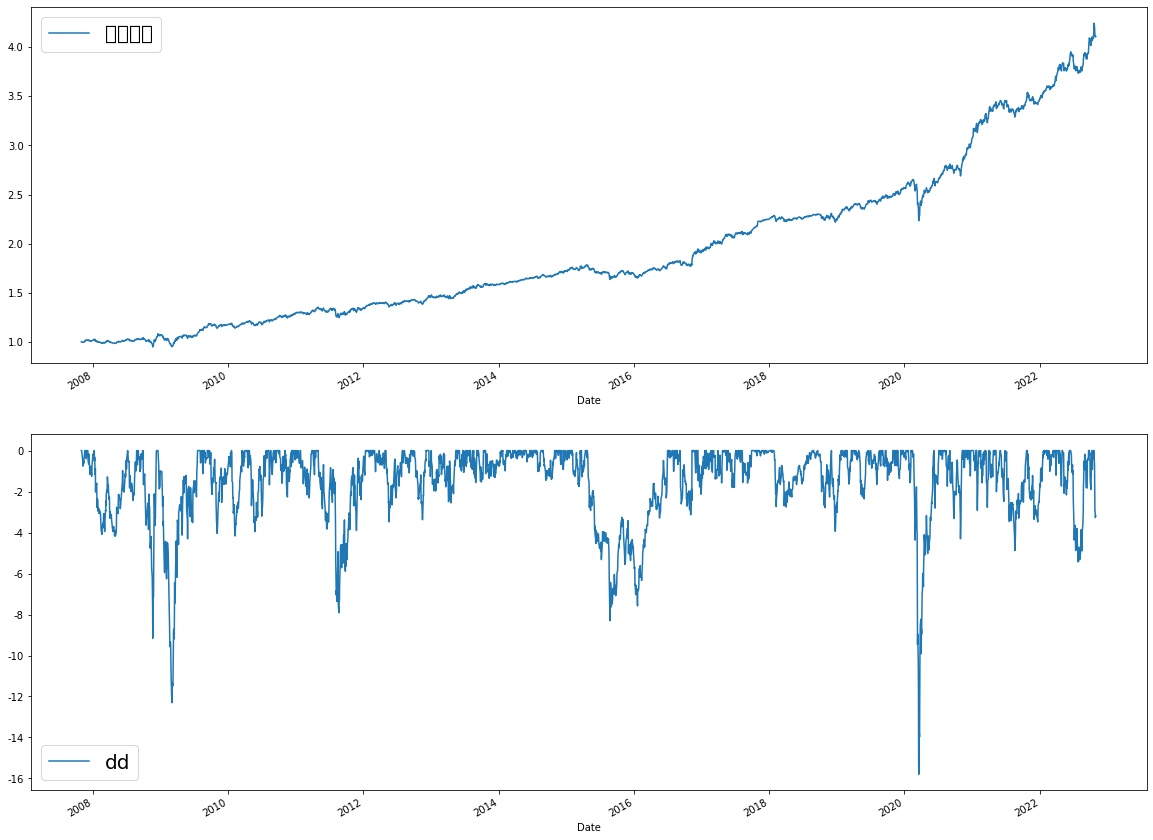

In [12]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,16))

# 수익곡선
plt.subplot(2,1,1)
CumReturn.plot(label="수익곡선")
plt.legend(fontsize=20)

# dd 곡선
plt.subplot(2,1,2)
(-dd).plot(label="dd")
plt.legend(fontsize=20)

plt.show()